# LPC


![Corte sagital do trato vocal (Wikipedia)](imgs/Sagittalmouth.png)

Um codificador de fonte utiliza um modelo matemático para a fonte produtora dos sinal que desejamos codificar/transmitir. Se o sinal original corresponde a um sinal de voz, o codificador de fonte é chamado vocodes (*voice coder*). O exemplo mais comum é o LPC (linear predictive coder). 

A produção da fala pode ser compreendida como a geração de um sinal de excitação, através da expulsão de ar dos pulmões, podendo gerar turbulência e/ou vibração nas pregas vocais. Este sinal de excitação se propaga ao longo do trato vocal. Este processo, sob a ótica de processamento de sinais, pode ser compreendido como um modelo fonte filtro. 

![](imgs/lpc-scheme.png)

O LPC utiliza um modelo de predição linear para representar o modelo do envelope de espectro de um trecho de um sinal de voz. Desta forma, não é necessário transmitir/armazenar as amostras do sinal
de voz, mas apenas os parâmetros de excitação do filtro, o ganho e o filtro de predição linear.

O LPC supões então um modelo simplificado da fonte, podendo produzir um trem de pulsos (para trechos vozeados de fala) ou ruído branco (para trechos não vozeados de fala). O primeiro passo então é determinar se o sinal que será codificado é vozeado ou não. Podemos utilizar a autocorreção para realizar esta distinção, conforme veremos no exemplo abaixo.

Além de determinar as características da fonte, devemos determinar o filtro que melhor representar o sistema do trato vocal em um determinado trecho do sinal de fala.

![](imgs/lpc-scheme2.png)

O LPC analisa o sinal de voz realizando um estimativa dos formantes, removendo o efeitos destes no sinal de fala, e estimando a intensidade e frequência do zumbido remanescente. O processo de remover o efeito dos formantes é chamado de filtragem inversa, e o sinal remanescente após a subtração do sinal modelado filtrado é chamado de resı́duo. Os parâmetros que descrevem a intensidade e frequência do zumbido, os formantes, e o sinal de resı́duo, podem ser armazenados ou transmitidos. 

A sı́ntese LPC do sinal de fala utiliza o processo inverso: utiliza os parâmetros do zumbido e o resı́duo para criar sinal da fonte, utiliza os formantes para criar um filtro (que representa a cavidade do trato vocal), e passa o sinal da fonte pelo filtro, resultando no sinal de fala. Como o sinal de fala varia ao longo do tempo, este processo é feito em pequenos trechos de sinal de fala, chamados quadros; usualmente de 30 a 50 quadros por segundo são utilizados para fornecer um sinal com boa compressão e fala inteligı́vel.


In [1]:
#URL="https://archive.org/download/78_on-a-bicycle-built-for-two-daisy-bell_dinah-shore-harry-dacre-paul-wetstein_gbia0061230b/On%20a%20Bicycle%20Built%20for%20Two%20%28Daisy%20Bell%29%20-%20Dinah%20Shore.mp3"
#URL="https://ia800609.us.archive.org/32/items/BicycleBuiltForTwo/bicycle_built_for_2_feb16_2012.ogg"
URL="https://ia800204.us.archive.org/13/items/BicycleBuiltForTwo_201602/Bicycle%20Built%20For%20Two.ogg"
if [ ! -f "/tmp/Daisy.wav" ]; then
  wget -q $URL -O /tmp/Daisy.ogg
  ffmpeg -i /tmp/Daisy.ogg /tmp/Daisy.wav 
fi

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

Na codificação LPC devemos determinar se um sinal é vozeado ou não. Caso seja vozeado devemos determinar a sua frequência fundamental (f0). Os dois problemas podem ser resolvidos através da função de auto-correlação. 

Vamos analisar com uma amostra de áudio da vogal 'a'. 

In [2]:
if [ ! -f "/tmp/ah.ogg" ]; then
  wget -q https://web.uvic.ca/ling/resources/ipa/charts/IPAlab/IPAsounds/open_front_unrounded.mp3 -O /tmp/ah.mp3
  ffmpeg -i /tmp/ah.mp3 /tmp/ah.ogg 
fi

OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set


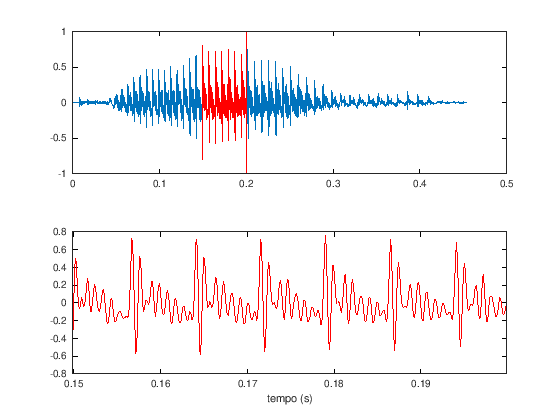

In [3]:
pkg load signal
pkg load communications

[x, fs] = audioread ('/tmp/ah.ogg');
x = x(9E3:29E3); % remover silencio
x = decimate(x,5);
fs = fs/5;
t = [0:1/fs:(length(x)-1)/fs]; 
start=round(0.15*fs);
wl = round(50E-3 * fs); % 40 ms
figure; subplot(2,1,1); plot(t,x); hold on; plot(t(start:start+wl),x(start:start+wl),'r');
line([t(start) t(start)],get(gca,'YLim'),'Color',[1 0 0]);
line([t(start+wl) t(start+wl)],get(gca,'YLim'),'Color',[1 0 0]);
subplot(2,1,2); plot(t(start:start+wl),x(start:start+wl),'r'); 
xlim([t(start),t(start+wl)]); xlabel('tempo (s)');

Ao analisar um trecho da vogal, podemos verificar que o sinal é quasi-periódico. Para determinar a frequência fundamental, vamos utilizar a função de auto-correlação e encontrar o pico.

Primeiro vamos definir uma função para localizar picos.

In [4]:
function [pks,locs] = findpeaks(data)
% [pks,locs] = findpeaks(data)
%   find the peaks values on vector data
  n = length(data);
  locs = find([data(2:n,1) - data(1:n-1,1) < 0; 1] & [1; data(1:n-1,1) - data(2:n,1) < 0]);
  pks = data(locs);
endfunction 

Em seguida vamos analisar os picos de autocorrelação do sinal.

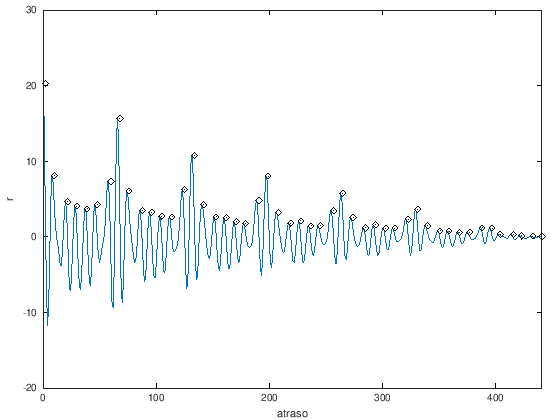

In [5]:
[r,l] = xcorr(x(start:start+wl));
[pks,locs] = findpeaks(r(wl:end));
figure; plot(l(wl:end),r(wl:end)); hold on; plot(locs,pks,'dk');
xlim([0, wl]); ylabel('r'); xlabel('atraso');

Queremos determinar o segundo maior pico. Para tanto vamos ordenar o vetor e selecionar o segundo. O segundo pico de auto-correlação ocorre após passar um quasi-período.

In [6]:
[_,id] = sort(pks,"descend");
T0 = locs(id(2))/fs;
f0 = 1/T0;
printf("a frequencia fundamental é f0=%.1f Hz.",f0);

a frequencia fundamental é f0=129.7 Hz.
a frequencia fundamental é f0=129.7 Hz.


Quando o sinal não for vozeado, não existirão picos proeminentes. Podemos então estabelecer um limiar para considerar um pico como válido. Se existirem picos acima deste limiar, poderemos considerar o sinal como vozeado. Faça um teste com trechos de sinal não vozeado e verifique o comportamento.


Podemos utilizar o modelo LPC para representar a vogal dada. Já determinamos a frequência fundamental. Devemos agora determinar o filtro, utilizando para tanto a função **lpc**.

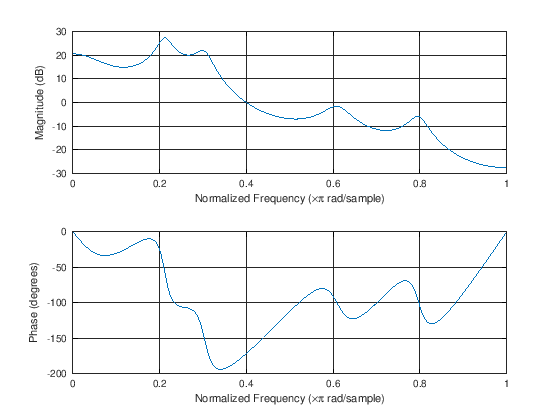

In [7]:
p = 12; % ordem do modelo
[a, g] = lpc (x, p);
freqz(1,a);

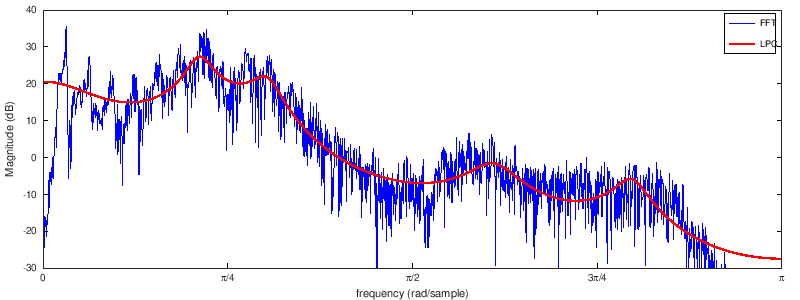

In [8]:
X = fft(x);
N = floor(length(X)/2);
[H, W] = freqz (1, a, N);
figure(1, 'position',[0,0,800,300]);
plot(W,20*log10(abs(X(1:N))),'b-',W,20*log10(H),'r-','linewidth',5); 
xlim([0 pi]); ylim([-30 40]); legend('FFT','LPC'); 
set(gca,'xtick',[0 pi/4 pi/2 3*pi/4 pi], 'xticklabel',{'0','\pi/4','\pi/2','3\pi/4','\pi'});
xlabel('frequency (rad/sample)'); ylabel('Magnitude (dB)');

In [9]:
ra = roots(a);
id = find(imag(ra)>0); % selecionar apenas um polo de cada par
ra = ra(id);
[_,id] = sort(abs(ra),'descend');
F = (fs/2)*angle(ra(id(1:4)))/pi;
printf("frequencia dos 4 primeiros formantes (Hz): %.1f, %.1f, %.1f, %.1f", F);

frequencia dos 4 primeiros formantes (Hz): 933.7, 1340.4, 3515.4, 2691.2
frequencia dos 4 primeiros formantes (Hz): 933.7, 1340.4, 3515.4, 2691.2


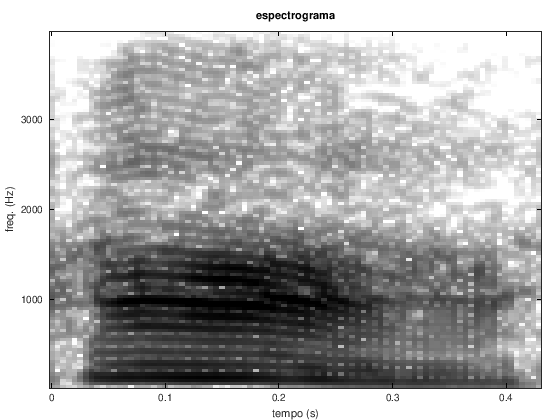

In [10]:
step = fix(5*fs/1000); # one spectral slice every 5 ms
window = fix(20*fs/1000);  # 20 ms data window
fftn = 2^nextpow2(window); # next highest power of 2
[S, f, tt] = specgram(x, fftn, fs, window, window-step);
S = abs(S(2:fftn*4000/fs,:)); # magnitude in range 0<f<=4000 Hz
S = S/max(S(:)); 
S = max(S, 10^(-30/10));   # clip below -30 dB.
S = min(S, 10^(-2/10));    # clip above -2 dB.
imagesc (tt, f(2:fftn*4000/fs), log(S));    # display in log scale
set (gca, "ydir", "normal");
cmap=repmat([255:-1:0]'/255,1,3);
colormap(cmap);
xlabel('tempo (s)'); ylabel('freq. (Hz)'); title('espectrograma');

In [11]:
function x = createpulsetrain(fs,d,f0,jit,shim)
%
%  x = createpulsetrain(fs,d,f0,jit)
%  fs : frequencia de amostragem do sinal
%  d : duracao desejada do trem de pulsos a ser gerado (segundos)
%  f0 : frequencia fundamental 
%  jit : percentual de jitter [0,1]
%  shim : percentual de shimmer [0,1]
%
%
%  Jitter and shimmer represent the variations that occur in the fundamental frequency. 
%  Whereas jitter indicates the variability or perturbation of fundamental frequency, 
%  shimmer refers to the same perturbation, but it is related to amplitude of sound wave, 
%  or intensity of vocal emission. Jitter is affected mainly because of lack of control of 
%  vocal fold vibration and shimmer with reduction of glottic resistance and mass lesions 
%  in the vocal folds, which are related with presence of noise at emission and breathiness
%
if jit < 0 || jit > 1, error('jitter must be in ther inverval [0,1]'); endif;
if shim < 0 || shim > 1, error('shimmer must be in ther inverval [0,1]'); endif;
if f0 > fs/2, error('are you crazy?'); endif;

L = d * fs; % desired length (samples)
i = 0; x = [];
while(length(x) < L),
   f0r = (jit*f0)*rand + f0;
   lag = round(fs / f0r);
   x = [x  zeros(1,lag-1) (1-shim*rand)];
endwhile
if(length(x) > L), x = x(1:L); endif;
endfunction

In [12]:
sig = createpulsetrain(fs,length(x)/fs,f0,0.05,0.1);
xr = filter(1,a,sig);
sound(xr,fs);

ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
connect(2) call to /dev/shm/jack-1000/default/jack_0 failed (err=No such file or directory)
attempt to connect to server failed
connect(2) call to /dev/shm/jack-1000/default/jack_0 failed (err=No such file or directory)
attempt to connect to server failed
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_oss.c:377:(_snd_pcm_oss_open) Unknown field port
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_usb_stream.c:486:(_snd_pcm_usb_stream_open) Invalid type for card
ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
connect(2) call to /dev/shm/jack-1

In [13]:
function x = createexcitation(fs,d,f0,jit,shim)

if f0 == 0, % noise
  x = 2*(rand (1, floor( d * fs )) - 0.5);
else
  x = createpulsetrain(fs,d,f0,jit,shim);
endif

endfunction

In [14]:
function X = slidingwindow(x, fs, wlength, overlap)

if ( isrow(x) ), x = x'; endif;

wl = round(wlength*fs); % window length
ov = round(overlap*fs); % overlap
nov = wl-ov; % no overlap
nwin = floor( (length(x)-ov)/nov );
maxlen = nwin*nov + ov;
X = [];
for i = 0 : nwin-1,
  X(:,i+1) = x(i*nov+1:i*nov+wl);
endfor;

endfunction

In [15]:
function f0 = findf0(X,fs)
%
%  f0 = findf0(X,fs)
%     encontra o valor da frequencia fundamental do sinal x
%     f0 : frequencia fundamental
%     X : sinal (or matriz with a signal in each column)
%     fs : frequencia de amostragem do sinal
%

if (isrow(X)), X = X'; endif;

f0 = [];
for i = 1 : size(X,2),
  f0(i) = 0;
  % auto-correlacao de x
  [R, lag] = xcorr(X(:,i),X(:,i),'coeff');

  % considerar apenas metade do vetor de auto-correlacao
  % vamos selecionar apenas as amostras da metade até o final
  R = R(ceil(length(R)/2):end);
  lag = lag(ceil(length(lag)/2):end);

  % encontrar os picos de auto-correlacao
  [pks,locs] = findpeaks(R);

  % se encontrou mais do que um pico (pois sempre haverá um pico em zero)
  if(length(pks) > 1),
    % ordenar os picos encontrados
    [Rsort,idxR] = sort(pks);
    if Rsort(end-1) > 0.2, % vozeado
       lagF0 = 1; dd = 1;
       while( fs/lagF0 < 20 || fs/lagF0 > 250 ), % o valor do pitch deve ser entre 20 e 250 Hz
          if dd == length(idxR), f0(i) = 0; break; endif % nao encontrou
          % calcula a distancia (numero de amostras) entre o pico em zero e o proximo pico
          lagF0 = locs(idxR(end-dd)) - locs(idxR(end));
          % calcula o valor de f0 em Hz
          f0(i) = fs/lagF0;
          % incrementar o valor da variavel dd para pegar o proximo pico, caso
          % o pico utilizado forneca um valor de f0 fora da faixa desejada
          dd++;
       endwhile
    %else
    %  f0(i) = 0; % nao vozeado
    endif
  endif
endfor
endfunction

In [16]:
function x = swin2signal(X, fs, overlap)
ov = round(overlap*fs); % overlap
wl = size(X,1);
nov = wl-ov;
nwin = size(X,2);
x = zeros(nwin*nov+ov,1);
x(1:wl) = tanh( X(:,1) );
for i = 1 : nwin-1, % for each window
  x(i*nov+1:(i+1)*nov+ov) += tanh( X(:,i+1) );
  x(i*nov+1:i*nov+ov) /= 2;
endfor
endfunction

In [17]:
filename = '/tmp/Daisy.wav';

order = 12;
[x, fs] = audioread (filename);
x = resample(x,1,5);
fs = fs/5;

% Pre-emphasis
pre = [1 -0.9];
x = filter(pre,1,x);

% window
winlength = 15E-3; %15ms
overlap = 7.5E-3;  %7.5ms
X = slidingwindow (x, fs, winlength, overlap);
hwindow = hamming(size(X,1));
X .*= hwindow;
[a g] = lpc(X, order);
f0 = findf0(X,fs);
f0 = round(f0);

% synthesis
Xs = [];
for w = 1 : length(f0), % for each window
  sig = createexcitation(fs,size(X,1)/fs,f0(w),0,0);
  Xs(:,w) = sqrt(g(w))*filter(1,a(w,:),sig);
endfor
Xs .*= hwindow;
speech = swin2signal(Xs, fs, overlap);
speech ./= max(speech);

% De-emphasis (must match pre-emphasis in lpcfit)
pre = [1 -0.9];
speech = filter (1, pre, speech);
audiowrite ('synthesized-daisy.ogg', speech, fs);
system ('play synthesized-daisy.ogg');

play WARN alsa: can't encode 0-bit Unknown or not applicable

synthesized-daisy.ogg:

 File Size: 112k      Bit Rate: 19.5k
  Encoding: Vorbis        
  Channels: 1 @ 16-bit   
Samplerate: 4800Hz       
Replaygain: off         
  Duration: 00:00:46.16  

In:100%  00:00:46.16 [00:00:00.00] Out:222k  [      |      ] Hd:0.5 Clip:0    
Done.
